Дано: кредитные истории клиентов одного из банков.   
Поля в предоставляемых данных имеют следующий смысл:
- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)   
- SEX: пол клиента (1 = мужской, 2 = женский )   
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).   
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).    
- AGE: возраст в годах   
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)    
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь    
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре    
- default - индикатор невозврата денежных средств    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv("credit_card_default_analysis.csv")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
repayment = data[data.default == 0]
loan = data[data.default == 1]

C:\Users\Egor\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


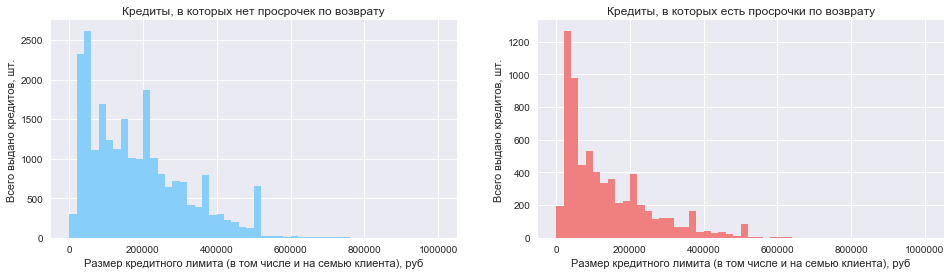

In [5]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
repayment.LIMIT_BAL.hist(color='lightskyblue', bins = 50, range = (0, 1000000))
pylab.xlabel(u'Размер кредитного лимита (в том числе и на семью клиента), руб')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет просрочек по возврату')
pylab.legend()

pylab.subplot(1,2,2)
loan.LIMIT_BAL.hist(color='lightcoral', bins = 50, range = (0, 1000000))
pylab.xlabel(u'Размер кредитного лимита (в том числе и на семью клиента), руб')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть просрочки по возврату')
pylab.legend()

Построим 95% доверительный интервал для разности медиан и проверим, входит ли туда 0. Для этого используем метода бутстреп, так как он не делает предположений о распределении.

In [6]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
np.random.seed(0)

repayments_median = map(np.median, get_bootstrap_samples(repayment.LIMIT_BAL.values, 1000))
loans_median  = map(np.median, get_bootstrap_samples(loan.LIMIT_BAL.values, 1000))

In [8]:
delta_median = map(lambda x: x[1] - x[0], zip(loans_median, repayments_median))

In [9]:
print "95% доверительный интервал для медианы кредитов, в которых нет просрочек:",  stat_intervals(repayments_median, 0.05)
print "95% доверительный интервал для медианы кредитов, в которых есть просрочки по возврату:",  stat_intervals(loans_median, 0.05)
print "95% доверительный интервал для разности медиан:",  stat_intervals(delta_median, 0.05)

95% доверительный интервал для медианы кредитов, в которых нет просрочек: [ 150000.  150000.]
95% доверительный интервал для медианы кредитов, в которых есть просрочки по возврату: [ 80000.  90000.]
95% доверительный интервал для разности медиан: [ 60000.  70000.]


интервалы для медиан лимитов отличаются (разница не содержат 0). А значит гипотезу о равенстве медиан отвергаем. 

#### Равны ли распределения в обоих группах? 

Для проверки воспользуемся перестановочным критерием для независимых выборок.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
print "p-value: %f" % permutation_test(repayment.LIMIT_BAL.values, loan.LIMIT_BAL.values, max_permutations = 5000)

p-value: 0.000200


p-value довольно мало, гипотеза о равенстве распределений отвергается. 

вывод: признак LIMIT_BAL значим.

## Пол (SEX)

In [12]:
dataFromMens = data[data['SEX'] == 1]
dataFromWomans = data[data['SEX'] == 2]

quntityRepaymentsFromMens = len(dataFromMens[dataFromMens['default'] == 0])
quntityLoansFromMens = len(dataFromMens[dataFromMens['default'] == 1])
quntityRepaymentsFromWomens = len(dataFromWomans[dataFromWomans['default'] == 0])
quntityLoansFromWomens = len(dataFromWomans[dataFromWomans['default'] == 1])

N = 2
repaymentsFromMensWomans = (quntityRepaymentsFromMens, quntityRepaymentsFromWomens)
loansFromMensWomans = (quntityLoansFromMens, quntityLoansFromWomens)

ind = np.arange(N)    
width = 0.35  

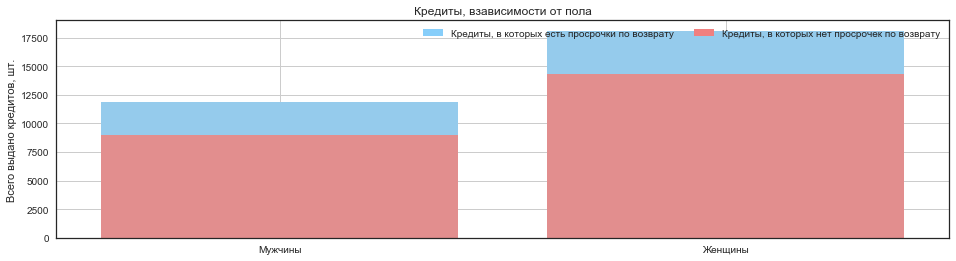

In [14]:
plt.figure(figsize(16,4))

sns.set_style("white")

sns.barplot(x = ind, y = repaymentsFromMensWomans, color = "lightcoral")
sns.barplot(x = ind, y = loansFromMensWomans, color = "lightskyblue", bottom=repaymentsFromMensWomans)

bar1 = plt.Rectangle((0,0),1,1,fc="lightskyblue", edgecolor = 'none')
bar2 = plt.Rectangle((0,0),1,1,fc='lightcoral',  edgecolor = 'none')
l = plt.legend([bar1, bar2], [u'Кредиты, в которых есть просрочки по возврату', u'Кредиты, в которых нет просрочек по возврату'], loc=1, ncol = 2, prop={'size':10})
plt.title(u'Кредиты, взависимости от пола')
plt.xticks(ind, (u'Мужчины', u'Женщины'))
plt.ylabel(u'Всего выдано кредитов, шт.')
plt.grid(True)

Проверка гипотезы сводится к проверке следующих утверждений:

$H_0\colon p_1 = p_2$       - доли одинаковы

$H_1\colon p_1 \neq\ p_2$     - доли разные  

Для этого воспользуемся Z-критерием для разности долей в независимых выборках.

In [16]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [17]:
mensList = data[data.SEX == 1].default.tolist()
womansList = data[data.SEX == 2].default.tolist()

In [18]:
print "95%% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами: [%f, %f]" %proportions_diff_confint_ind(mensList, womansList)
print "p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(mensList, womansList))

95% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами: [0.024207, 0.043612]
p-value:  4.47286652161e-12


Вывод: доли (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами статистически различаются (p-value < 0.05). В тоже время эта разница с практической т.з. является мизерной (от 2,4% до 4,3%). Поэтому признак SEX при построение модели можно считать незначимым.

## Образование (EDUCATION)

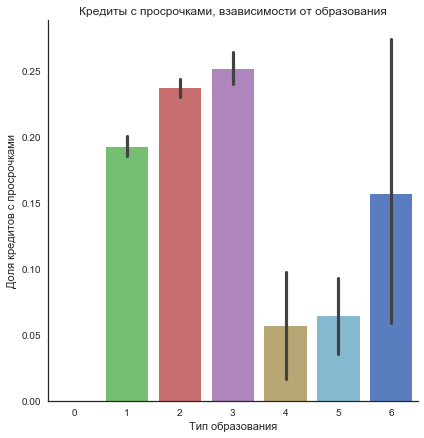

In [19]:
sns.factorplot(x='EDUCATION', y='default',  data=data, kind="bar", palette="muted", size = 6)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Тип образования')
plt.title(u'Кредиты с просрочками, взависимости от образования')

У докторов наук (EDUCATION=0) вообще нет просрочек по кредитам. Также небольшой процент невозврата у окончивших лишь начальную школу (EDUCATION=4) и указавших свое образование как "другое" (EDUCATION=5). Значительный высокий процент невозврата у окончивших школу (EDUCATION=3), получивших высшее образование бакалавров (EDUCATION=2) и тех, кто не указал свое образование (EDUCATION=6). Поэтому необходимо считать признак EDUCATION как важным при построение модели.

Проверим, зависимы ли тип образования и наличие/отсутствие просрочек в оплате кредита. Для этого воспользуемся критерием хи-квадрат. Нулевая гипотеза $H_0$: подвыборки образования заемщиков вернувших и не вернувших кредит -- независимы, альтернативная $H_a$: нулевая гипотеза неверна.    
Предварительно составим таблицу сопряженности для образования и возврата / не возврата кредита:

In [20]:
tableEducationVSDefault = pd.DataFrame({u'Без просрочек': data[data['default'] == 0].EDUCATION.value_counts(), u'С просрочками': data[data['default'] == 1].EDUCATION.value_counts()})
tableEducationVSDefault.iloc[0,1] = 0
tableEducationVSDefault

,Без просрочек,С просрочками
0,14,0.0
1,8549,2036.0
2,10700,3330.0
3,3680,1237.0
4,116,7.0
5,262,18.0
6,43,8.0


In [21]:
def v_cramer(chi, n, shape):
    return np.sqrt(chi/n/(min(shape[0], shape[1])-1))

n = len(data) 
print "p-value: ", stats.chi2_contingency(tableEducationVSDefault, correction=False)[1]
print 'v_cramer: ', v_cramer(stats.chi2_contingency(tableEducationVSDefault, correction=False)[0], n, tableEducationVSDefault.shape)

p-value:  1.23326262454e-32
v_cramer:  0.0737600971325


Вывод: гипотеза о независимости образования и наличия/отсутствия просрочек в оплате кредита отвергается.EDUCATION является важным при рассмотрении заявки на кредит.

## Семейное положение (MARRIAGE)

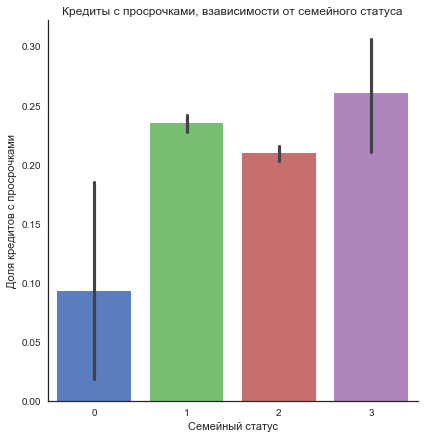

In [22]:
sns.factorplot(x='MARRIAGE', y='default',  data=data, kind="bar", palette="muted", size = 6)
plt.ylabel(u'Доля кредитов с просрочками')
plt.xlabel(u'Семейный статус')
plt.title(u'Кредиты с просрочками, взависимости от семейного статуса')

Самая малая доля кредитов с просрочками у тех, кто отказался указывать свой семейный статус (MARRIAGE=0). У остальных категорий  примерно одинаковые доли кредитов с просрочками (MARRIAGE=1 - замужем/женат; MARRIAGE=2 - холост; MARRIAGE=3 - нет данных). Поэтому признак MARRIAGE необходимо считать как важный при построении модели.

In [23]:
tableMarriageVSDefault = pd.DataFrame({u'Без просрочек': data[data['default'] == 0].MARRIAGE.value_counts(), u'С просрочками': data[data['default'] == 1].MARRIAGE.value_counts()})
tableMarriageVSDefault

,Без просрочек,С просрочками
2,12623,3341
1,10453,3206
3,239,84
0,49,5


In [24]:
n = len(data) 
print "p-value: ", stats.chi2_contingency(tableMarriageVSDefault, correction=False)[1]
print 'v_cramer: ', v_cramer(stats.chi2_contingency(tableMarriageVSDefault, correction=False)[0], n, tableMarriageVSDefault.shape)

p-value:  8.82586245758e-08
v_cramer:  0.0344782036628


Выводы: гипотеза о независимости семейного статуса и наличия/отсутствия просрочек в оплате кредита отвергается. MARRIAGE является важным при рассмотрении заявки на кредит.

## Возраст (AGE)

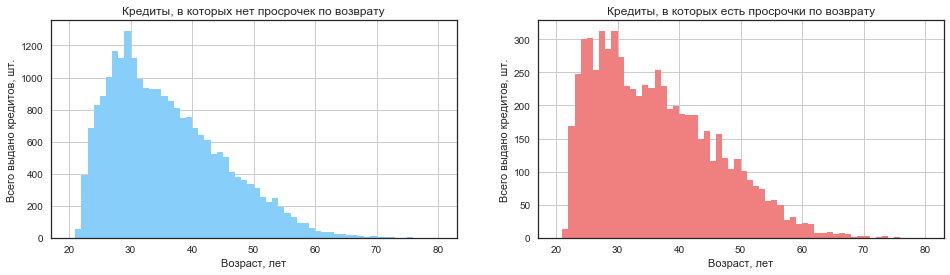

In [25]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
repayment.AGE.hist(color='lightskyblue', bins = 60, range = (20, 80))
pylab.xlabel(u'Возраст, лет')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых нет просрочек по возврату')
pylab.legend()

pylab.subplot(1,2,2)
loan.AGE.hist(color='lightcoral', bins = 60, range = (20, 80))
pylab.xlabel(u'Возраст, лет')
pylab.ylabel(u'Всего выдано кредитов, шт.')
plt.title(u'Кредиты, в которых есть просрочки по возврату')
pylab.legend()

#### Равны ли медианы значений возрастов людей в обоих группах?

In [26]:
np.random.seed(123)

repayments_median = map(np.median, get_bootstrap_samples(repayment.AGE.values, 1000))
loans_median  = map(np.median, get_bootstrap_samples(loan.AGE.values, 1000))

In [27]:
delta_medianForAge = map(lambda x: x[1] - x[0], zip(loans_median, repayments_median))

In [28]:
print "95% доверительный интервал для медианы кредитов, в которых нет просрочек:",  stat_intervals(repayments_median, 0.05)
print "95% доверительный интервал для медианы кредитов, в которых есть просрочки по возврату:",  stat_intervals(loans_median, 0.05)
print "95% доверительный интервал для разности медиан:",  stat_intervals(delta_medianForAge, 0.05)

95% доверительный интервал для медианы кредитов, в которых нет просрочек: [ 34.  34.]
95% доверительный интервал для медианы кредитов, в которых есть просрочки по возврату: [ 34.  35.]
95% доверительный интервал для разности медиан: [-1.  0.]


Вывод: 0 входит в доверительный интервал, поэтому однозначно мы не можем сказать, что есть разница в медианых значений возраста в кредитах у которых нет просрочек и кредитах, где они есть.

#### Равны ли распределения в обоих группах?

Для проверки воспользуемся перестановочным критерием для независимых выборок.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [29]:
print "p-value: %f" % permutation_test(repayment.AGE.values, loan.AGE.values, max_permutations = 5000)

p-value: 0.016400


гипотеза о равенстве распредений отвергается.

вывод: ввиду того, что доверительный интервал содержит ноль и в тоже время p-value < 0,05 мы не можем однозначно определить зависимость от возраста. Для более точных оценок необходимо больше данных. 